# Attention Visualization

**The goal of this notebook is to the attention weights learned by the model for each position on the grid.** 

The red cross shows the position from which we are calculating the weights. As shown by the plots, the model mainly learns to pay attention to the current position on the grid in the energy and probability models.

In [1]:
import torch
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader, RandomSampler
from tqdm.notebook import tqdm

from models.probability_models import ProbabilityAttentionRNN, ProbabilityAttentionRNN2D
from models.energy_models import EnergyAttentionRNN, EnergyAttentionRNN2D
from data_utils.pytorch_datasets import EnergyDataset, EnergyDataset2D
from plotting_utils.attention import attention_2D_viz, attention_1D_viz

In [2]:
energy_attn_ckpt = './model_weights/energy/rnn_attn/GRU_1L_1H_Bi/model.ckpt'
energy_2D_attn_ckpt = './model_weights/energy/rnn_attn/2D_GRU_1L_1H_Bi/model.ckpt'
prob_attn_ckpt = './model_weights/probability/rnn_attn/GRU_1L_1H_Bi/model.ckpt'
prob_2D_attn_ckpt = './model_weights/probability/rnn_attn/2D_GRU_1L_1H_Bi/model.ckpt'

energy_attn = EnergyAttentionRNN.load_from_checkpoint(energy_attn_ckpt)
energy_attn.eval()

energy_attn_2D = EnergyAttentionRNN2D.load_from_checkpoint(energy_2D_attn_ckpt)
energy_attn_2D.eval()

prob_attn = ProbabilityAttentionRNN.load_from_checkpoint(prob_attn_ckpt)
prob_attn.eval();

prob_attn_2D = ProbabilityAttentionRNN2D.load_from_checkpoint(prob_2D_attn_ckpt)
prob_attn.eval();

In [3]:
train_data_path = './data/train_data.hdf5'
batch_size = 128
n_random_samples = 3200

dataset = EnergyDataset2D(filepath=train_data_path)
random_sampler = RandomSampler(dataset, num_samples=n_random_samples, replacement=True)
loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=random_sampler,
    num_workers=0)

In [4]:
attn_2D_rows = {}
attn_2D_cols = {}

attn_1D = {}
with torch.no_grad():
    for x_row, x_col, y in tqdm(loader):
        y_pred, attn_weights = energy_attn_2D(x_row, x_col)
        if y_pred.shape[0] == batch_size:
            attn_2D_rows['energy_2D'] = attn_2D_rows.get('energy_2D', 0) + attn_weights[0]
            attn_2D_cols['energy_2D'] = attn_2D_cols.get('energy_2D', 0) + attn_weights[1]
            
        y_pred, attn_weights = energy_attn(x_row)
        if y_pred.shape[0] == batch_size:
            attn_1D['energy'] = attn_1D.get('energy', 0) + attn_weights
        
        y_pred, attn_weights = prob_attn_2D(x_row, x_col)
        if y_pred.shape[0] == batch_size:
            attn_2D_rows['prob_2D'] = attn_2D_rows.get('prob_2D', 0) + attn_weights[0]
            attn_2D_cols['prob_2D'] = attn_2D_cols.get('prob_2D', 0) + attn_weights[1]
        
        y_pred, attn_weights = prob_attn(x_row)
        if y_pred.shape[0] == batch_size:
            attn_1D['prob'] = attn_1D.get('prob', 0) + attn_weights

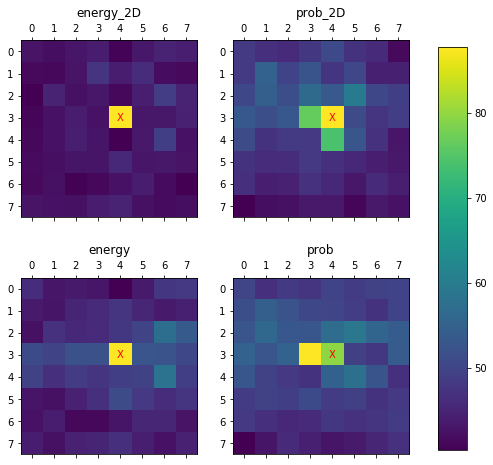

In [5]:
row, col = 3, 4
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
for i, model_key in enumerate(attn_2D_rows.keys()):
    attn_weights_sum = (attn_2D_rows[model_key], attn_2D_cols[model_key])
    attn_viz = attention_2D_viz(attn_weights_sum, row, col)
    attn_viz[0, 0] = np.mean(attn_viz)
    ax[0, i].matshow(attn_viz)
    ax[0, i].text(col, row, "X",ha="center", va="center", color="r")
    ax[0, i].set_title(model_key, y=1.10)

for i, model_key in enumerate(attn_1D.keys()):
    attn_viz = attention_1D_viz(attn_1D[model_key], row, col)
    attn_viz[0, 0] = np.mean(attn_viz)
    im = ax[1, i].matshow(attn_viz)
    ax[1, i].text(col, row, "X",ha="center", va="center", color="r")
    ax[1, i].set_title(model_key, y=1.10)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax);